The purpose of this notebook is to examine the performance of LDA-based approach
The steps include:
1. Respectively train two LDA models using "review" dataset and "sentence" dataset, and compare the performance of them
2. Train a suitable LDA model and identify topic about food environment
3. Evaluate the performance of LDA approach to classify food-environment-related texts

Prepare two types of datasets to train LDA models.

In [0]:
import pandas as pd

dataframes=[]

for i in range(0, 2):
  dataframes.append(pd.read_csv('/gdrive/My Drive/Processed/Review%s.csv' % str(i+1), usecols=[1,4]))
 
df=pd.concat(dataframes)
corpus=[]
corpus1=[]

'''
Prepare two types of dataset
'''
for i, r in df.iterrows():
    corpus.append(str(r[1]))
  
for i, r in df.iterrows():
    for sent in str(r[1]).split(','):
        corpus1.append(sent)
        
print(corpus[0])
print(corpus1[0])

lovely stay maia home welcome maia also friendly silvy cat,maia keep busy club sport available friendly conversation dinner tv comfortable live room,maia online response prompt,room large storage desk,bed comfortable,also storage kitchen available,short walk house armley town centre store bank library,city reachable via direct bus route hr walk feel adventurous,silvy like deposit white hair clothe suppose blame pet,recommend stay someone accustom like cat
lovely stay maia home welcome maia also friendly silvy cat


In [0]:
from nltk.stem.porter import PorterStemmer
import gensim
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
doc_sets = [[stemmer.stem(token) for token in gensim.utils.simple_preprocess(tokens) if token not in stop_words] for tokens in corpus]

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
doc_sets1 = [[stemmer.stem(token) for token in gensim.utils.simple_preprocess(tokens) if token not in stop_words] for tokens in corpus1]

In [0]:
print(doc_sets[0])
print(doc_sets1[0])

['love', 'stay', 'maia', 'home', 'welcom', 'maia', 'also', 'friend', 'silvi', 'cat', 'maia', 'keep', 'busi', 'club', 'sport', 'avail', 'friend', 'convers', 'dinner', 'tv', 'comfort', 'live', 'room', 'maia', 'onlin', 'respons', 'prompt', 'room', 'larg', 'storag', 'desk', 'bed', 'comfort', 'also', 'storag', 'kitchen', 'avail', 'short', 'walk', 'hous', 'armley', 'town', 'centr', 'store', 'bank', 'librari', 'citi', 'reachabl', 'via', 'direct', 'bus', 'rout', 'hr', 'walk', 'feel', 'adventur', 'silvi', 'like', 'deposit', 'white', 'hair', 'cloth', 'suppos', 'blame', 'pet', 'recommend', 'stay', 'someon', 'accustom', 'like', 'cat']
['love', 'stay', 'maia', 'home', 'welcom', 'maia', 'also', 'friend', 'silvi', 'cat']


In [0]:
from gensim import corpora, models
import gensim

dictionary = corpora.Dictionary(doc_sets)
dictionary.filter_n_most_frequent(15)
dictionary.filter_extremes(no_below=50, no_above=0.5, keep_n=10000)
#print(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in doc_sets]

dictionary1 = corpora.Dictionary(doc_sets1)
dictionary1.filter_n_most_frequent(15)
dictionary1.filter_extremes(no_below=50, no_above=0.5, keep_n=10000)
#print(dictionary.token2id)
corpus1 = [dictionary1.doc2bow(text) for text in doc_sets1]

Respectively train two kinds of LDA models and compare the performance

In [9]:
from gensim.models.coherencemodel import CoherenceModel

coherences = []
for i in range(5, 31, 5):
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=i, 
                                               random_state=98-i,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=4)
    goodcm = CoherenceModel(model=lda_model, texts=doc_sets, dictionary=dictionary, coherence='c_v')
    coherences.append(goodcm.get_coherence())
print(coherences)
    

coherences1 = []
for i in range(5, 31, 5):
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus1,
                                               id2word=dictionary1,
                                               num_topics=i, 
                                               random_state=50-i,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=4)
    goodcm = CoherenceModel(model=lda_model, texts=doc_sets1, dictionary=dictionary1, coherence='c_v')
    coherences1.append(goodcm.get_coherence())
print(coherences1)

[0.5721924506982206, 0.5115085822252504, 0.5006287490477572, 0.5028751124322663, 0.5079748559255235, 0.49838361423889144]
[0.3851133932230476, 0.3651847674769229, 0.35351884992768834, 0.34698871753431354, 0.33713911784954753, 0.31860487708489676]


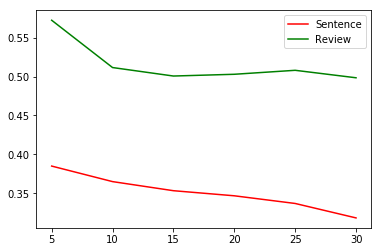

<Figure size 1440x720 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

y=[5, 10, 15, 20, 25, 30]

fig,ax = plt.subplots()
ax.plot(y, coherences1, label="Sentence", color='r')
ax.plot(y, coherences, label="Review", color='g')
plt.legend(loc='best')
plt.figure(figsize=(20,10))
plt.show()

Train LDA models five times and choose the best one

In [0]:
import pandas as pd
import nltk
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

def preprocess(text):
    '''
    preprocess raw data: tokenization, remove stopwords, and lemmatization
    '''
    tokens = simple_preprocess(text)
    
    stop_words = stopwords.words('english')
    stop_words.extend(['london', 'leeds', 'u', 'would', 'could', 'us'])
    
    lemmatizer = WordNetLemmatizer()
    
    tokens = [lemmatizer.lemmatize(token, 'n') for token in tokens if token not in stop_words]
    return tokens

def predict(model, related_topic, text):
    bow = dictionary.doc2bow(preprocess(text))
    bow_vector=model[bow]
    flag=0
    for i, s in bow_vector[0]:
        if i==related_topic and s>0.2:
            flag=True
            break
    return 1

def batch_predict(model, related_topic, text_list):
    processed_list=[preprocess(text) for text in text_list]
    return [predict(model, related_topic, text) for text in processed_list]

In [14]:
lda_model1 = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=20, 
                                               random_state=10000,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=4)
lda_model1.print_topics(num_topics=20, num_words=10)

[(0,
  '0.144*"easi" + 0.091*"check" + 0.071*"communic" + 0.040*"access" + 0.031*"flexibl" + 0.029*"good" + 0.029*"get" + 0.028*"make" + 0.021*"excel" + 0.019*"accommod"'),
 (1,
  '0.181*"transport" + 0.087*"public" + 0.047*"close" + 0.035*"descript" + 0.033*"link" + 0.032*"good" + 0.030*"jan" + 0.026*"accur" + 0.023*"confort" + 0.022*"total"'),
 (2,
  '0.054*"restaur" + 0.037*"area" + 0.036*"shop" + 0.030*"lot" + 0.028*"local" + 0.022*"close" + 0.020*"nearbi" + 0.018*"neighborhood" + 0.018*"pub" + 0.018*"bar"'),
 (3,
  '0.091*"breakfast" + 0.040*"thank" + 0.027*"enjoy" + 0.027*"cat" + 0.027*"welcom" + 0.026*"shani" + 0.026*"hous" + 0.025*"morn" + 0.024*"much" + 0.023*"friend"'),
 (4,
  '0.052*"quiet" + 0.026*"good" + 0.025*"relax" + 0.025*"garden" + 0.022*"valu" + 0.022*"area" + 0.021*"friend" + 0.021*"hous" + 0.020*"peac" + 0.019*"bright"'),
 (5,
  '0.090*"back" + 0.064*"come" + 0.053*"exact" + 0.050*"describ" + 0.049*"definit" + 0.048*"look" + 0.034*"time" + 0.029*"pictur" + 0.028*"

In [16]:
df=pd.read_csv('/gdrive/My Drive/Test/test_extraction1.csv', error_bad_lines=False)
test_set=[str(r[0]) for i,r in df.iterrows()]
test_labels=[int(r[1]) for i,r in df.iterrows()]
predicted_labels=batch_predict(lda_model1, 2, test_set)

from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For the first model:")
print("Accuracy: "+str(round(accuracy,3)), "Precision: "+str(round(precision, 3)), "Recall" +str(round(recall, 3)), "F-measure" +str(round(fscore, 3)))

For the first model:
Accuracy: 0.714 Precision: 0.676 Recall: 0.635 F-measure: 0.655


In [17]:
lda_model2 = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=20, 
                                               random_state=1234,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=2)
lda_model2.print_topics(num_topics=20, num_words=10)

[(0,
  '0.104*"transport" + 0.050*"quick" + 0.049*"public" + 0.027*"close" + 0.026*"richard" + 0.021*"conveni" + 0.021*"king" + 0.021*"respond" + 0.020*"fabul" + 0.019*"tourist"'),
 (1,
  '0.042*"look" + 0.032*"visit" + 0.030*"day" + 0.026*"trip" + 0.024*"airport" + 0.022*"paul" + 0.022*"plan" + 0.021*"return" + 0.021*"famili" + 0.020*"next"'),
 (2,
  '0.130*"home" + 0.081*"make" + 0.071*"feel" + 0.065*"welcom" + 0.041*"felt" + 0.040*"like" + 0.030*"hous" + 0.021*"warm" + 0.020*"friend" + 0.018*"thank"'),
 (3,
  '0.057*"tube" + 0.042*"restaur" + 0.040*"close" + 0.035*"central" + 0.034*"shop" + 0.028*"easi" + 0.028*"area" + 0.022*"street" + 0.021*"park" + 0.021*"well"'),
 (4,
  '0.216*"everyth" + 0.180*"need" + 0.071*"perfect" + 0.032*"ann" + 0.019*"groceri" + 0.018*"provid" + 0.016*"thank" + 0.014*"definit" + 0.014*"brilliant" + 0.012*"studio"'),
 (5,
  '0.057*"well" + 0.049*"friend" + 0.045*"welcom" + 0.042*"high" + 0.037*"hous" + 0.035*"bed" + 0.032*"perfect" + 0.031*"beauti" + 0.031

In [18]:
predicted_labels=batch_predict(lda_model2, 3, test_set)

from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For the second model:")
print("Precision: "+str(round(precision, 3)), "Recall" +str(round(recall, 3)), "F-measure" +str(round(fscore, 3)))

For the second model:
Accuracy: 0.707 Precision: 0.687 Recall: 0.632 F-measure: 0.658


In [19]:
lda_model3 = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=20, 
                                               random_state=99,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=2)
lda_model3.print_topics(num_topics=20, num_words=10)

[(0,
  '0.056*"check" + 0.045*"describ" + 0.045*"exact" + 0.042*"get" + 0.039*"arriv" + 0.032*"time" + 0.031*"meet" + 0.029*"easi" + 0.021*"flexibl" + 0.021*"even"'),
 (1,
  '0.035*"arriv" + 0.035*"morn" + 0.034*"breakfast" + 0.030*"even" + 0.025*"tea" + 0.024*"leav" + 0.021*"provid" + 0.020*"coffe" + 0.020*"day" + 0.018*"earli"'),
 (2,
  '0.199*"everyth" + 0.146*"need" + 0.060*"perfect" + 0.042*"pictur" + 0.031*"absolut" + 0.026*"juli" + 0.024*"thank" + 0.018*"definit" + 0.018*"richard" + 0.014*"wonder"'),
 (3,
  '0.115*"easi" + 0.068*"access" + 0.063*"central" + 0.056*"distanc" + 0.055*"super" + 0.054*"within" + 0.035*"walk" + 0.026*"go" + 0.025*"communic" + 0.023*"get"'),
 (4,
  '0.134*"home" + 0.079*"make" + 0.077*"welcom" + 0.074*"feel" + 0.042*"felt" + 0.033*"like" + 0.028*"warm" + 0.023*"friend" + 0.020*"hous" + 0.015*"enjoy"'),
 (5,
  '0.024*"cat" + 0.022*"janet" + 0.022*"alway" + 0.020*"pleasur" + 0.017*"appart" + 0.016*"problem" + 0.016*"person" + 0.016*"peopl" + 0.015*"hous"

In [20]:
predicted_labels=batch_predict(lda_model3, 6, test_set)

from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For the third model:")
print("Precision: "+str(round(precision, 3)), "Recall" +str(round(recall, 3)), "F-measure" +str(round(fscore, 3)))

For the third model:
Accuracy: 0.707 Precision: 0.687 Recall: 0.632 F-measure: 0.658


In [21]:
lda_model4 = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=20, 
                                               random_state=98,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=2)
lda_model4.print_topics(num_topics=20, num_words=10)

[(0,
  '0.072*"close" + 0.072*"transport" + 0.065*"train" + 0.057*"station" + 0.052*"central" + 0.034*"public" + 0.032*"good" + 0.029*"conveni" + 0.024*"underground" + 0.022*"near"'),
 (1,
  '0.040*"night" + 0.033*"get" + 0.031*"day" + 0.030*"even" + 0.025*"arriv" + 0.025*"time" + 0.020*"one" + 0.019*"leav" + 0.017*"late" + 0.015*"though"'),
 (2,
  '0.081*"experi" + 0.068*"airbnb" + 0.064*"first" + 0.041*"look" + 0.039*"better" + 0.029*"view" + 0.022*"expect" + 0.020*"soon" + 0.019*"hotel" + 0.019*"photo"'),
 (3,
  '0.097*"diann" + 0.044*"amaz" + 0.043*"wonder" + 0.042*"airport" + 0.039*"cozi" + 0.038*"valu" + 0.031*"high" + 0.029*"lynn" + 0.027*"money" + 0.025*"gracious"'),
 (4,
  '0.144*"home" + 0.083*"welcom" + 0.079*"feel" + 0.074*"make" + 0.042*"felt" + 0.040*"hous" + 0.033*"like" + 0.032*"warm" + 0.028*"friend" + 0.022*"thank"'),
 (5,
  '0.045*"time" + 0.030*"go" + 0.029*"back" + 0.027*"hous" + 0.025*"come" + 0.021*"thank" + 0.021*"give" + 0.020*"everyth" + 0.019*"make" + 0.018*"

In [22]:
predicted_labels=batch_predict(lda_model4, 16, test_set)

from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For the fourth model:")
print("Precision: "+str(round(precision, 3)), "Recall" +str(round(recall, 3)), "F-measure" +str(round(fscore, 3)))

For the fourth model:
Accuracy: 0.717 Precision: 0.693 Recall: 0.621 F-measure: 0.655


In [23]:
lda_model5 = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=20, 
                                               random_state=97,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=2)
lda_model5.print_topics(num_topics=20, num_words=10)

[(0,
  '0.077*"julia" + 0.039*"photo" + 0.038*"squar" + 0.029*"attract" + 0.024*"accomod" + 0.023*"size" + 0.022*"look" + 0.020*"brick" + 0.019*"els" + 0.019*"leicest"'),
 (1,
  '0.042*"get" + 0.036*"even" + 0.033*"arriv" + 0.027*"night" + 0.024*"day" + 0.023*"leav" + 0.022*"time" + 0.021*"go" + 0.019*"meet" + 0.018*"make"'),
 (2,
  '0.070*"well" + 0.043*"give" + 0.036*"area" + 0.035*"inform" + 0.027*"provid" + 0.025*"local" + 0.022*"lot" + 0.022*"advic" + 0.019*"also" + 0.018*"direct"'),
 (3,
  '0.068*"view" + 0.050*"amaz" + 0.049*"perfect" + 0.043*"citi" + 0.034*"store" + 0.032*"center" + 0.032*"beauti" + 0.031*"janic" + 0.025*"richard" + 0.025*"st"'),
 (4,
  '0.061*"alway" + 0.029*"give" + 0.027*"week" + 0.027*"tip" + 0.026*"diana" + 0.023*"privaci" + 0.021*"interest" + 0.018*"tube" + 0.017*"chat" + 0.016*"link"'),
 (5,
  '0.163*"good" + 0.092*"transport" + 0.059*"safe" + 0.049*"neighbourhood" + 0.044*"public" + 0.029*"close" + 0.024*"friend" + 0.024*"quiet" + 0.022*"area" + 0.018*"

In [24]:
predicted_labels=batch_predict(lda_model5, 13, test_set)

from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print()
print("Precision: "+str(round(precision, 3)), "Recall" +str(round(recall, 3)), "F-measure" +str(round(fscore, 3)))

For the fifth model:
Accuracy: 0.701 Precision: 0.679 Recall: 0.636 F-measure: 0.657
